# Gather and experiment with possible features for uni vs multi domain classification

In order to eventually build a classifier for evolutionary randomness, first we need to solve the subproblem of uni vs multi domain.
Therefore, this experiment should first aim to download relevant datasets and features (AlphaFold vs ECOD/Alphafold intersection). Then, we want to get a feeling for which features are most useful.

In [1]:
import glob
import gzip
import re

import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from pqdm.threads import pqdm
from aiohttp import ClientSession

In [2]:
# parser = PDBParser(QUIET=True)
# def read_structure_features_from_file_bp(file: str):
#     uni_prot_id = re.search(r"AF-([A-Z0-9]+)-", file).group(1)
#     with gzip.open(file, "rt") as handle:
#         structure = parser.get_structure(uni_prot_id, handle)
#         seq_len = len(list(structure.get_residues()))
#         min_pLDDT = min([a.bfactor for a in structure.get_atoms()])
#     return uni_prot_id, seq_len, min_pLDDT

def read_structure_features_from_file_custom(file: str):
    uni_prot_id = re.search(r"AF-([A-Z0-9]+)-", file).group(1)
    seq_len = 0
    min_pLDDT = 100
    with gzip.open(file, "rt") as handle:
        for line in handle:
            # The sequence length is written in the DBREF line at the end
            if line.startswith('DBREF'):
                seq_len = int(line.rstrip().split()[-1])
            # The pLDDT is the last number in each ATOM line
            elif line.startswith('ATOM'):
                pLDDT = float(line[-20:-13])
                if pLDDT < min_pLDDT:
                    min_pLDDT = pLDDT
    return uni_prot_id, seq_len, min_pLDDT

def get_alphafold_scores(file: str) -> (str, int, float):
    uni_prot_id, seq_len, min_pLDDT = read_structure_features_from_file_custom(file)
    return uni_prot_id, seq_len, min_pLDDT

In [3]:
%%timeit
uniprot_id, seq_len, min_plddt = get_alphafold_scores("../data/alphafold/v2/UP000000429_85962_HELPY_v2/AF-G5EB01-F1-model_v2.pdb.gz")

1.15 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
def read_features_from_file(file: str):
    uniprot_id, seq_len, min_plddt = get_alphafold_scores(file)
    return {
        "uniprot_id": uniprot_id,
        "seq_len": seq_len,
        "min_plddt": min_plddt,
    }

def read_features_for_proteome(folder: str):
    files = glob.glob(f"{folder}/*.pdb.gz")
    proteome = re.search(r"_([A-Z0-9]+)_v2", folder).group(1)
    seq_infos = pqdm(files, read_features_from_file, n_jobs=10, desc=f'Files in {folder}')
    df = pd.DataFrame(seq_infos)
    df.to_csv(f'../data/alphafold/v2/AA_scores/{proteome}.csv')

In [4]:
finished_proteomes = [re.search(r"/([A-Z0-9]+).csv", file).group(1) for file in glob.glob("../data/alphafold/v2/AA_scores/*.csv")]
folders = list(filter(lambda folder: re.search(r"_([A-Z0-9]+)_v2", folder).group(1) not in finished_proteomes, glob.glob("../data/alphafold/v2/*_v2")))

In [5]:
if len(folders) > 0:
    pqdm(folders, read_features_for_proteome, n_jobs=3, desc='Folders')

SUBMITTING | Folders:   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING | Folders:   0%|          | 0/1 [00:00<?, ?it/s]

SUBMITTING | Files in ../data/alphafold/v2/UP000005640_9606_HUMAN_v2:   0%|          | 0/23391 [00:00<?, ?it/s…

PROCESSING | Files in ../data/alphafold/v2/UP000005640_9606_HUMAN_v2:   0%|          | 0/23391 [00:00<?, ?it/s…

COLLECTING | Files in ../data/alphafold/v2/UP000005640_9606_HUMAN_v2:   0%|          | 0/23391 [00:00<?, ?it/s…

COLLECTING | Folders:   0%|          | 0/1 [00:00<?, ?it/s]

### Extend with maximal PAE

In [2]:
all_proteome_files = glob.glob("../data/alphafold/v2/AA_scores/*.csv")
proteomes_with_max_pae = pd.read_csv("../data/alphafold/v2/proteomes_with_max_pae.csv", header=None)
proteomes_with_max_pae_list = proteomes_with_max_pae.squeeze('columns').to_list()
proteome_files = list(filter(lambda file: re.search(r"/([A-Z0-9]+).csv", file).group(1) not in proteomes_with_max_pae_list, all_proteome_files))

In [3]:
async def get_max_pae(session: ClientSession, uniprot_id: str) -> float:
    res = None
    try:
        response = await session.get(url=f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-predicted_aligned_error_v2.json")
        data = await response.json(content_type=None)
        res = max(data[0]["distance"])
    except:
        pass
    return res

async def extend_proteome_features_with_max_pae(session: ClientSession, proteome_file: str):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'max_pae' not in proteome_df:
        proteome_df['max_pae'] = None
    proteome_df['max_pae'] = pd.to_numeric(proteome_df['max_pae'], errors='coerce')
    to_fill = proteome_df[proteome_df['max_pae'].isnull()].index
    if len(to_fill) == 0:
        proteomes_with_max_pae.loc[len(proteomes_with_max_pae.index)] = [proteome]
        proteomes_with_max_pae.to_csv('../data/alphafold/v2/proteomes_with_max_pae.csv', header=False, index=False)
        print('Already filled with max PAE')
        return
    splits = np.array_split(to_fill, len(to_fill) / 1000 + 1)
    for i, fill_split in enumerate(splits):
        proteome_df.loc[fill_split, 'max_pae'] = await tqdm.gather(
            *[get_max_pae(session, uid) for uid in proteome_df['uniprot_id'][fill_split]],
            desc=f'Sequences in {proteome}, split {i + 1}/{len(splits)}')
        proteome_df.to_csv(f'../data/alphafold/v2/AA_scores/{proteome}.csv')
    del proteome_df
    proteome_df = ''

In [4]:
async with ClientSession() as session:
    file_splits = np.array_split(proteome_files, len(proteome_files) / 5 + 1)
    for i, file_split in enumerate(file_splits):
        await tqdm.gather(*[extend_proteome_features_with_max_pae(session, file) for file in file_split],
                          desc=f'Proteomes split {i + 1}/{len(file_splits)}')

Proteomes split 1/1: 0it [00:00, ?it/s]

### Introduce labels from uniProt

I use information from [uniprot.org](https://www.uniprot.org/uniprot/O76074#family_and_domains) to check how many domains a sequence has.
! This uses AlphaFold predictions too !

In [11]:
async def load_domain_count(session: ClientSession, uniprot_id: str) -> int:
    res = 0
    try:
        response = await session.get(url=f"https://www.uniprot.org/uniprot/{uniprot_id}.txt")
        domain_count = 0
        async for line in response.content:
            if 'FT   DOMAIN' in line.decode():
                domain_count += 1
        res = domain_count
    except:
        pass
    return res

async def extend_proteome_features_with_domain_count(session: ClientSession, proteome_file: str):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'domain_count' not in proteome_df:
        proteome_df['domain_count'] = None
    proteome_df['domain_count'] = pd.to_numeric(proteome_df['domain_count'], errors='coerce')
    to_fill = proteome_df[proteome_df['domain_count'].isnull()].index
    if len(to_fill) == 0:
        proteomes_with_domain_count.loc[len(proteomes_with_domain_count.index)] = [proteome]
        proteomes_with_domain_count.to_csv('../data/alphafold/v2/proteomes_with_domain_count.csv', header=False, index=False)
        print('Already filled with domain count')
        return
    splits = np.array_split(to_fill, len(to_fill) / 10000 + 1)
    for i, fill_split in enumerate(splits):
        proteome_df.loc[fill_split, 'domain_count'] = await tqdm.gather(
            *[load_domain_count(session, uid) for uid in proteome_df['uniprot_id'][fill_split]],
            desc=f'Sequences in {proteome}, split {i + 1}/{len(splits)}')
        proteome_df.to_csv(f'../data/alphafold/v2/AA_scores/{proteome}.csv')
    del proteome_df
    proteome_df = ''

In [13]:
all_proteome_files = glob.glob("../data/alphafold/v2/AA_scores/*.csv")
proteomes_with_max_pae = pd.read_csv("../data/alphafold/v2/proteomes_with_max_pae.csv", header=None)
proteomes_with_max_pae_list = proteomes_with_max_pae.squeeze('columns').to_list()
proteomes_with_domain_count = pd.read_csv("../data/alphafold/v2/proteomes_with_domain_count.csv", header=None)
proteomes_with_domain_count_list = proteomes_with_domain_count.squeeze('columns').to_list()
proteomes_to_extend_with_domain_count = set(proteomes_with_max_pae_list).difference(set(proteomes_with_domain_count_list))
proteome_files_without_domain = list(filter(lambda file: re.search(r"/([A-Z0-9]+).csv", file).group(1) in proteomes_to_extend_with_domain_count, all_proteome_files))

async with ClientSession() as session:
    file_splits = np.array_split(proteome_files_without_domain, len(proteome_files_without_domain) / 5 + 1)
    for i, file_split in enumerate(file_splits):
        await tqdm.gather(*[extend_proteome_features_with_domain_count(session, file) for file in file_split],
                          desc=f'Proteomes split {i + 1}/{len(file_splits)}')

Proteomes split 1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Already filled with domain count


### Plot the different features against each other

In [2]:
import matplotlib.pyplot as plt

In [12]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

# Human proteome has some without max PAE
df = df[df['max_pae'].notnull()]

In [5]:
%matplotlib notebook
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.scatter(df['seq_len'], df['max_pae'], df['min_plddt'])
ax.set_xlabel("Sequence length")
ax.set_ylabel("Max PAE")
ax.set_zlabel("Min pLDDT")
plt.show()

<IPython.core.display.Javascript object>

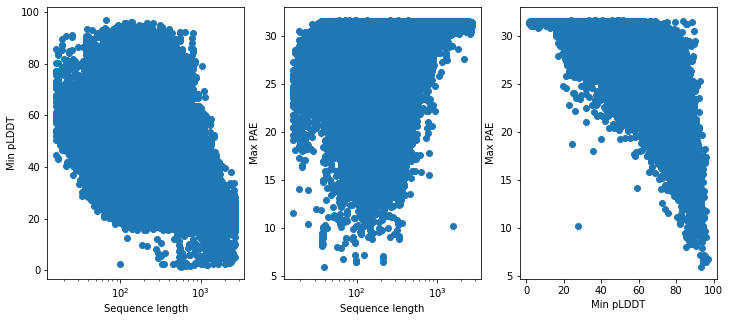

In [7]:
%matplotlib inline
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.scatter(df['seq_len'], df['min_plddt'])
ax1.set_xlabel("Sequence length")
ax1.semilogx()
ax1.set_ylabel("Min pLDDT")

ax2.scatter(df['seq_len'], df['max_pae'])
ax2.set_xlabel("Sequence length")
ax2.semilogx()
ax2.set_ylabel("Max PAE")

ax3.scatter(df['min_plddt'], df['max_pae'])
ax3.set_xlabel("Min pLDDT")
ax3.set_ylabel("Max PAE")

plt.show()

In [13]:
df.iloc[[df['seq_len'].values.argmax(), df['min_plddt'].values.argmin(), df['max_pae'].values.argmax()]]

,uniprot_id,seq_len,min_plddt,max_pae,domain_count,proteome
1477,Q6LA55,2699,18.48,31.2,0.0,SCHPO
8323,A0A3Q0KT14,574,1.39,31.3,0.0,SCHMA
21604,A0A1P8AUV5,81,48.25,31.7,0.0,ARATH


In [5]:
# Only use data with domain information
df_domain = df[df['domain_count'] > 0]
df_domain['multi_domain'] = (df_domain['domain_count'] > 1).replace({True: 1, False: 0}).values
df_domain.describe()

/var/folders/4x/bsjg71t57k33m23kg08vzb1h0000gn/T/ipykernel_23500/3534987212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_domain['multi_domain'] = (df_domain['domain_count'] > 1).replace({True: 1, False: 0}).values


,seq_len,min_plddt,max_pae,domain_count,multi_domain
count,204169.000000,204169.000000,204169.000000,204169.000000,204169.000000
mean,510.721735,32.719823,30.886558,1.529091,0.282937
std,369.761235,11.375134,1.501068,1.415701,0.450427
min,21.000000,1.460000,6.500000,1.000000,0.000000
25%,267.000000,25.070000,31.000000,1.000000,0.000000
50%,410.000000,29.760000,31.300000,1.000000,0.000000
75%,640.000000,36.700000,31.400000,2.000000,1.000000
max,2699.000000,95.790000,31.700000,46.000000,1.000000


In [7]:
df_means = df_domain.groupby(by='multi_domain').mean()
df_means

,seq_len,min_plddt,max_pae,domain_count
multi_domain,,,,
0,442.014098,33.888210,30.802103,1.000000
1,684.851178,29.758717,31.100597,2.869995


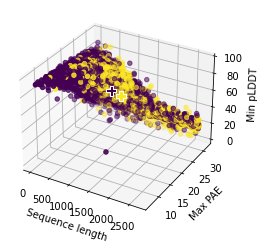

In [8]:
%matplotlib inline
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.computed_zorder = False
ax.scatter(df_domain['seq_len'], df_domain['max_pae'], df_domain['min_plddt'], c=df_domain['multi_domain'])
ax.scatter(df_means['seq_len'], df_means['max_pae'], df_means['min_plddt'], c=df_means.index,
           edgecolors='white', marker="P", s=100, zorder=20, depthshade=False)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Max PAE")
ax.set_zlabel("Min pLDDT")
plt.show()

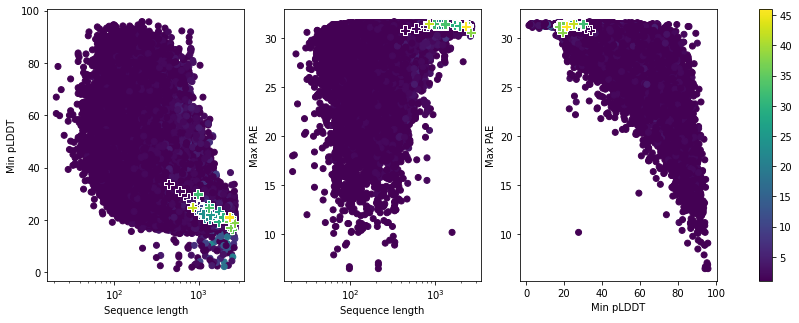

In [12]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

p = ax1.scatter(df_domain['seq_len'], df_domain['min_plddt'], c=df_domain['domain_count'], cmap='viridis')
ax1.scatter(df_means['seq_len'], df_means['min_plddt'], c=df_means.index, cmap='viridis', edgecolors='white', marker="P",
            s=100, zorder=20)
ax1.set_xlabel("Sequence length")
ax1.semilogx()
ax1.set_ylabel("Min pLDDT")

ax2.scatter(df_domain['seq_len'], df_domain['max_pae'], c=df_domain['domain_count'], cmap='viridis')
ax2.scatter(df_means['seq_len'], df_means['max_pae'], c=df_means.index, cmap='viridis', edgecolors='white', marker="P",
            s=100, zorder=20)
ax2.set_xlabel("Sequence length")
ax2.semilogx()
ax2.set_ylabel("Max PAE")

ax3.scatter(df_domain['min_plddt'], df_domain['max_pae'], c=df_domain['domain_count'], cmap='viridis')
ax3.scatter(df_means['min_plddt'], df_means['max_pae'], c=df_means.index, cmap='viridis', edgecolors='white', marker="P",
            s=100, zorder=20)
ax3.set_xlabel("Min pLDDT")
ax3.set_ylabel("Max PAE")

fig.colorbar(p, ax=(ax1, ax2, ax3))
plt.show()

In [10]:
length_buckets_indices = range(0, df_domain['seq_len'].max(), 250)
length_buckets = [df_domain[df_domain['seq_len'].between(i, i + 249)] for i in length_buckets_indices]
labels = [f'{i}-{i+249}' for i in length_buckets_indices]

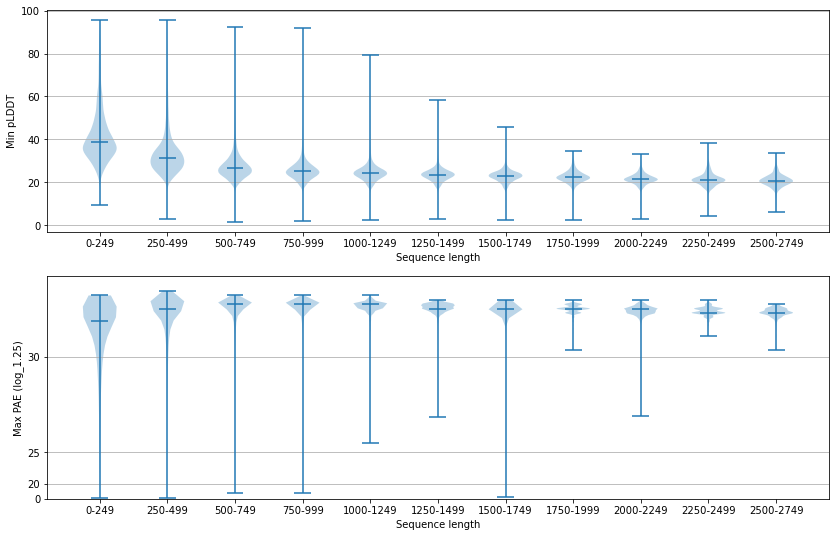

In [114]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(14, 9))

ax1.violinplot(dataset = [bucket['min_plddt'].values for bucket in length_buckets], showmedians=True)
ax1.yaxis.grid(True)
ax1.set_xlabel('Sequence length')
ax1.set_ylabel('Min pLDDT')
ax1.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

ax2.violinplot(dataset = [bucket['max_pae'].values for bucket in length_buckets], showmedians=True)
ax2.yaxis.grid(True)
ax2.set_xlabel('Sequence length')
ax2.set_ylabel('Max PAE (log_1.25)')
exp = lambda x: 1.25 ** x
log = lambda x: np.log(x) / np.log(1.25)
ax2.set_yscale('function', functions=(exp, log))
ax2.set(ylim=(0,32))
ax2.set_yticks([0, 20, 25, 30])
ax2.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

plt.show()

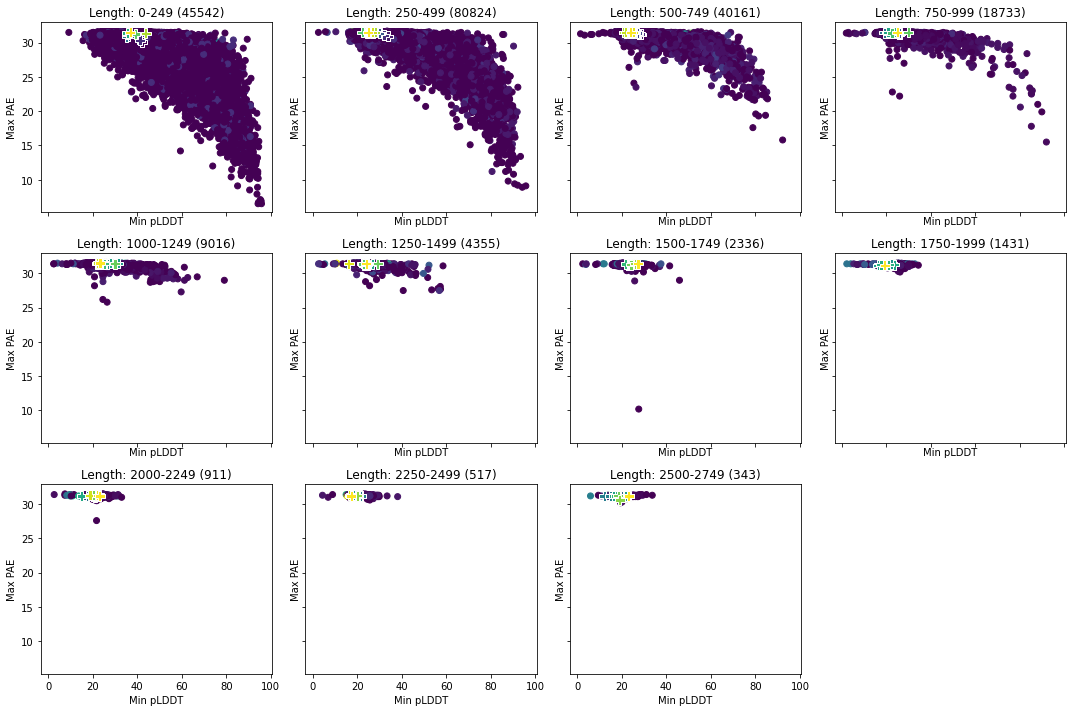

In [16]:
%matplotlib inline
nrows, ncols = 3, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True, sharey=True)

for i in range(len(axes)):
    for j in range(len(axes[i])):
        bucket_index = i * ncols + j
        if bucket_index >= len(length_buckets):
            fig.delaxes(axes[i, j])
            break
        bucket = length_buckets[bucket_index]
        bucket_means = bucket.groupby(by='domain_count').mean()
        axes[i, j].scatter(bucket['min_plddt'].values, bucket['max_pae'].values, c=bucket['domain_count'], cmap='viridis')
        axes[i, j].scatter(bucket_means['min_plddt'], bucket_means['max_pae'], c=bucket_means.index, cmap='viridis', edgecolors='white', marker="P",
            s=100, zorder=20)
        axes[i, j].set_title(f'Length: {labels[bucket_index]} ({len(bucket)})')
        axes[i, j].set_ylabel('Max PAE')
        axes[i, j].set_xlabel('Min pLDDT')

fig.tight_layout()
plt.show()

### Perform PCA to see if they cluster

In [8]:
from sklearn.decomposition import PCA

In [12]:
df_domain_features = df_domain[['seq_len', 'min_plddt', 'max_pae']]
df_features_normalized = (df_domain_features - df_domain_features.mean()) / df_domain_features.std()

In [13]:
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=3)
principal_components2 = pca2.fit_transform(df_features_normalized.values)
principal_components3 = pca3.fit_transform(df_features_normalized.values)

In [14]:
df_principal_components2 = pd.DataFrame(principal_components2, columns=['feat0', 'feat1'])
df_principal_components2['multi_domain'] = df_domain['multi_domain'].values
df_principal_components2.head()

,feat0,feat1,multi_domain
0,4.115110,1.276119,0
1,0.116967,-0.574090,0
2,-0.287503,-0.360580,0
3,4.382154,1.290845,0
4,1.449469,-0.152771,1


In [15]:
df_principal_components3 = pd.DataFrame(principal_components3, columns=['feat0', 'feat1', 'feat2'])
df_principal_components3['multi_domain'] = df_domain['multi_domain'].values
df_principal_components3.head()

,feat0,feat1,feat2,multi_domain
0,4.115110,1.276119,-0.093870,0
1,0.116967,-0.574090,0.032114,0
2,-0.287503,-0.360580,0.135444,0
3,4.382154,1.290845,0.177657,0
4,1.449469,-0.152771,-0.641114,1


In [17]:
df_pca_means2 = df_principal_components2.groupby(by='multi_domain').mean()
df_pca_means3 = df_principal_components3.groupby(by='multi_domain').mean()

In [51]:
%matplotlib notebook
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.computed_zorder = False
ax.scatter(df_principal_components3['feat0'], df_principal_components3['feat1'], df_principal_components3['feat2'], c=df_domain['multi_domain'])
ax.scatter(df_pca_means3['feat0'], df_pca_means3['feat1'], df_pca_means3['feat2'], c=df_pca_means3.index, edgecolors='white', marker="P", s=100, zorder=20, depthshade=False)
plt.show()

<IPython.core.display.Javascript object>

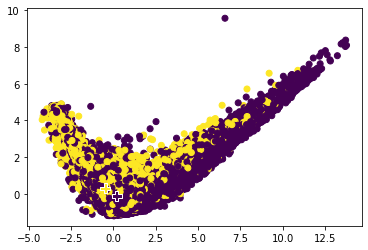

In [69]:
%matplotlib inline
fig = plt.figure()
plt.scatter(df_principal_components2['feat0'], df_principal_components2['feat1'], c=df_domain['multi_domain'])
plt.scatter(df_pca_means2['feat0'], df_pca_means2['feat1'], c=df_pca_means2.index, edgecolors='white', marker="P", s=100, zorder=20)
plt.show()

### Try SVM as baseline

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_features_normalized.values, df_domain['multi_domain'].values, test_size=0.25)

In [20]:
model = svm.LinearSVC(C=1)
clf = model.fit(X_train, y_train)

In [21]:
prediction = model.predict(X_test)

In [22]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83     36551
           1       0.58      0.14      0.22     14492

    accuracy                           0.73     51043
   macro avg       0.66      0.55      0.53     51043
weighted avg       0.69      0.73      0.66     51043



In [23]:
X_train_pca2, X_test_pca2, y_train_pca2, y_test_pca2 = train_test_split(
    df_principal_components2[['feat0', 'feat1']].values, df_domain['multi_domain'].values, test_size=0.25)

In [24]:
model_pca2 = svm.LinearSVC(C=1)
clf_pca2 = model_pca2.fit(X_train_pca2, y_train_pca2)

In [25]:
prediction_pca2 = model_pca2.predict(X_test_pca2)

In [26]:
print(classification_report(y_test_pca2, prediction_pca2))

              precision    recall  f1-score   support

           0       0.74      0.96      0.84     36653
           1       0.58      0.14      0.22     14390

    accuracy                           0.73     51043
   macro avg       0.66      0.55      0.53     51043
weighted avg       0.69      0.73      0.66     51043



In [27]:
X_train_pca3, X_test_pca3, y_train_pca3, y_test_pca3 = train_test_split(
    df_principal_components3[['feat0', 'feat1', 'feat2']].values, df_domain['multi_domain'].values, test_size=0.25)
model_pca3 = svm.LinearSVC(C=1)
clf_pca3 = model_pca3.fit(X_train_pca3, y_train_pca3)
prediction_pca3 = model_pca3.predict(X_test_pca3)
print(classification_report(y_test_pca3, prediction_pca3))

              precision    recall  f1-score   support

           0       0.74      0.96      0.84     36484
           1       0.60      0.14      0.23     14559

    accuracy                           0.73     51043
   macro avg       0.67      0.55      0.53     51043
weighted avg       0.70      0.73      0.66     51043



### Plot decision boundaries
[StackOverflow](https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python)

In [28]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [31]:
%matplotlib notebook
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x, y: (-clf.intercept_[0] - clf.coef_[0][0] * x - clf.coef_[0][1] * y) / clf.coef_[0][2]

tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(df_features_normalized['seq_len'], df_features_normalized['min_plddt'], df_features_normalized['max_pae'], c=df_domain['multi_domain'])
ax.plot_surface(x, y, z(x,y))
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
xx, yy = make_meshgrid(df_principal_components2['feat0'], df_principal_components2['feat1'])
plot_contours(ax, clf_pca2, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

ax.scatter(df_principal_components2['feat0'], df_principal_components2['feat1'], c=df_domain['multi_domain'], cmap=plt.cm.coolwarm)
ax.scatter(df_pca_means2['feat0'], df_pca_means2['feat1'], c=df_pca_means2.index, cmap=plt.cm.coolwarm, edgecolors='white', marker="P", s=100, zorder=20)
plt.show()

In [27]:
%matplotlib notebook
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x, y: (-clf_pca3.intercept_[0] - clf_pca3.coef_[0][0] * x - clf_pca3.coef_[0][1] * y) / clf_pca3.coef_[0][2]

tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(df_principal_components3['feat0'], df_principal_components3['feat1'], df_principal_components3['feat2'], c=df_domain['multi_domain'])
ax.plot_surface(x, y, z(x,y))
plt.show()

<IPython.core.display.Javascript object>